In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Load the data
file_path = '../data/sanity_check/output/participant_data_by_disease.csv'
data = pd.read_csv(file_path)

In [3]:
# Remove records with at least one null value, including the new column
data_cleaned = data.dropna()

In [4]:
obese_smoker_heart = data_cleaned[
    (data_cleaned['Body mass index (BMI) | Instance 0'] > 30) &
    (data_cleaned['Smoking status | Instance 0'] == 'Current') &
    (data_cleaned['label'] == 'Heart Disease')
]

healthy_non_smoker = data_cleaned[
    (data_cleaned['Body mass index (BMI) | Instance 0'].between(18, 24)) &
    (data_cleaned['Smoking status | Instance 0'] == 'Never') &
    (data_cleaned['label'] == 'Healthy')
]

In [5]:
obese_smoker_heart.shape

(829, 18)

In [6]:
healthy_non_smoker.shape

(4784, 18)

In [7]:
data_cleaned.head()

,eid,Age at recruitment,Sex,Cholesterol | Instance 0,LDL direct | Instance 0,HDL cholesterol | Instance 0,Triglycerides | Instance 0,Apolipoprotein A1 | Instance 0,Apolipoprotein B | Instance 0,Lipoprotein A | Instance 0,C-reactive protein | Instance 0,Glycated haemoglobin (HbA1c) | Instance 0,Creatinine | Instance 0,Cystatin C | Instance 0,Urate | Instance 0,Body mass index (BMI) | Instance 0,Smoking status | Instance 0,label
0,4848142,63,Male,4.453,2.716,0.807,4.649,1.3430,0.914,49.21,4.83,51.6,86.3,1.062,326.3,32.0017,Current,Heart Disease
1,3336283,63,Female,4.499,2.808,1.031,1.709,1.1217,0.887,28.22,0.55,31.8,62.6,0.915,193.3,28.2072,Never,Heart Disease
4,2765531,66,Female,4.788,3.051,0.960,2.275,1.1838,0.990,8.40,2.76,35.2,78.2,1.083,327.8,29.0311,Previous,Heart Disease
27,1218833,64,Female,4.268,2.678,0.791,2.569,1.0288,0.932,25.00,4.59,80.9,75.5,1.170,291.7,32.1427,Previous,Heart Disease
28,3382405,62,Female,5.551,3.732,1.097,1.992,1.3787,1.147,161.10,7.31,54.8,45.9,0.977,346.2,38.2150,Previous,Heart Disease


In [8]:
# Remove specified columns for PCA (excluding eid from removal)
columns_to_remove = ['Age at recruitment', 'Sex', 'Body mass index (BMI) | Instance 0', 'Smoking status | Instance 0']
data_cleaned = data_cleaned.drop(columns=columns_to_remove, errors='ignore')
obese_smoker_heart = obese_smoker_heart.drop(columns=columns_to_remove, errors='ignore')
healthy_non_smoker = healthy_non_smoker.drop(columns=columns_to_remove, errors='ignore')

# Split data by label
heart_disease_data = data_cleaned[data_cleaned['label'] == 'Heart Disease']
healthy_data = data_cleaned[data_cleaned['label'] == 'Healthy']

In [9]:
def apply_pca(data, label, color):
    # Separate features (excluding the label column)
    features = data.drop(columns=['label'])
    feature_names = features.columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(scaled_features)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)

    # Plotting with variation influence
    plt.scatter(pca_df['PC1'], pca_df['PC2'], label=label, c=color, alpha=0.5)

    # Print top contributing features for variation
    print(f"Top features affecting {label} variation:")
    for pc in ['PC1', 'PC2']:
        top_features = loadings[pc].abs().sort_values(ascending=False).head(2)
        print(f"{pc} top features: {top_features.index.tolist()} (Loadings: {top_features.values.round(3).tolist()})")

    return pca.explained_variance_ratio_

In [10]:
def apply_pca_3d(data, label):
    # Separate features (excluding the label column, keep eid for hover)
    features = data.drop(columns=['label'])
    feature_names = features.drop(columns=['eid']).columns
    pca_features = features.drop(columns=['eid'])  # Exclude eid from PCA
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pca_features)
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_features)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    pca_df['eid'] = features['eid'].values  # Add eid back for hover info
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=feature_names)

    # Print top contributing features for variation
    print(f"Top features affecting {label} variation:")
    for pc in ['PC1', 'PC2', 'PC3']:
        top_features = loadings[pc].abs().sort_values(ascending=False).head(2)
        print(f"{pc} top features: {top_features.index.tolist()} (Loadings: {top_features.values.round(3).tolist()})")

    return pca_df, pca.explained_variance_ratio_

Top features affecting Heart Disease variation:
PC1 top features: ['Cholesterol | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.515, 0.485])
PC2 top features: ['Triglycerides | Instance 0', 'HDL cholesterol | Instance 0'] (Loadings: [0.382, 0.379])
Top features affecting Healthy variation:
PC1 top features: ['Apolipoprotein B | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.478, 0.45])
PC2 top features: ['HDL cholesterol | Instance 0', 'Cholesterol | Instance 0'] (Loadings: [0.444, 0.43])


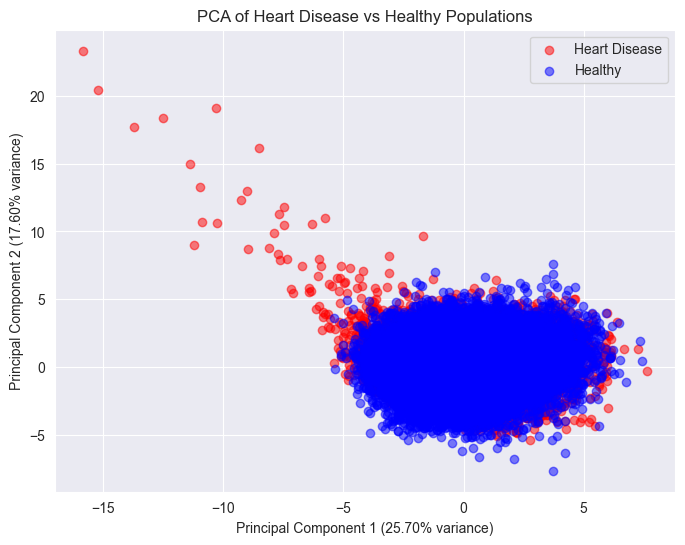

In [11]:
# Apply PCA to both groups
plt.figure(figsize=(8, 6))
variance_ratio_heart = apply_pca(heart_disease_data, 'Heart Disease', 'red')
variance_ratio_healthy = apply_pca(healthy_data, 'Healthy', 'blue')

# Plot customization
plt.title('PCA of Heart Disease vs Healthy Populations')
plt.xlabel(f'Principal Component 1 ({variance_ratio_heart[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({variance_ratio_heart[1]:.2%} variance)')
plt.legend()
plt.grid(True)
plt.show()



In [12]:
# Apply PCA to both groups
pca_df_heart, variance_ratio_heart = apply_pca_3d(heart_disease_data, 'Heart Disease')
pca_df_healthy, variance_ratio_healthy = apply_pca_3d(healthy_data, 'Healthy')

# Create interactive 3D scatter plot
fig = go.Figure()

# Add Heart Disease data with eid in hover
fig.add_trace(go.Scatter3d(
    x=pca_df_heart['PC1'],
    y=pca_df_heart['PC2'],
    z=pca_df_heart['PC3'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.6),
    name='Heart Disease',
    hovertemplate='eid: %{customdata}<extra></extra>',
    customdata=pca_df_heart['eid']
))

# Add Healthy data with eid in hover
fig.add_trace(go.Scatter3d(
    x=pca_df_healthy['PC1'],
    y=pca_df_healthy['PC2'],
    z=pca_df_healthy['PC3'],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.6),
    name='Healthy',
    hovertemplate='eid: %{customdata}<extra></extra>',
    customdata=pca_df_healthy['eid']
))

# Update layout
fig.update_layout(
    title='3D PCA of Heart Disease vs Healthy Populations',
    scene=dict(
        xaxis_title=f'PC1 ({variance_ratio_heart[0]:.2%} variance)',
        yaxis_title=f'PC2 ({variance_ratio_heart[1]:.2%} variance)',
        zaxis_title=f'PC3 ({variance_ratio_heart[2]:.2%} variance)'
    ),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()

Top features affecting Heart Disease variation:
PC1 top features: ['Cholesterol | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.515, 0.485])
PC2 top features: ['Triglycerides | Instance 0', 'HDL cholesterol | Instance 0'] (Loadings: [0.382, 0.379])
PC3 top features: ['Creatinine | Instance 0', 'Cystatin C | Instance 0'] (Loadings: [0.522, 0.498])
Top features affecting Healthy variation:
PC1 top features: ['Apolipoprotein B | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.478, 0.45])
PC2 top features: ['HDL cholesterol | Instance 0', 'Cholesterol | Instance 0'] (Loadings: [0.444, 0.43])
PC3 top features: ['Creatinine | Instance 0', 'Cystatin C | Instance 0'] (Loadings: [0.517, 0.417])


In [13]:
def filter_users_by_list(df, user_list):
    return df[df['eid'].isin(user_list)]

user_list = [5495790]
filtered_df = filter_users_by_list(data, user_list)

filtered_df.head()

,eid,Age at recruitment,Sex,Cholesterol | Instance 0,LDL direct | Instance 0,HDL cholesterol | Instance 0,Triglycerides | Instance 0,Apolipoprotein A1 | Instance 0,Apolipoprotein B | Instance 0,Lipoprotein A | Instance 0,C-reactive protein | Instance 0,Glycated haemoglobin (HbA1c) | Instance 0,Creatinine | Instance 0,Cystatin C | Instance 0,Urate | Instance 0,Body mass index (BMI) | Instance 0,Smoking status | Instance 0,label
36424,5495790,55,Female,5.743,3.666,1.208,2.458,1.276,1.109,16.42,5.73,28.3,612.1,6.986,364.7,21.6931,Previous,Heart Disease


In [14]:
obese_smoker_heart.shape

(829, 14)

In [15]:
healthy_non_smoker.shape

(4784, 14)

Top features affecting Heart Disease variation:
PC1 top features: ['Cholesterol | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.541, 0.522])
PC2 top features: ['Cystatin C | Instance 0', 'Creatinine | Instance 0'] (Loadings: [0.488, 0.47])
Top features affecting Healthy variation:
PC1 top features: ['LDL direct | Instance 0', 'Apolipoprotein B | Instance 0'] (Loadings: [0.546, 0.537])
PC2 top features: ['HDL cholesterol | Instance 0', 'Apolipoprotein A1 | Instance 0'] (Loadings: [0.504, 0.484])


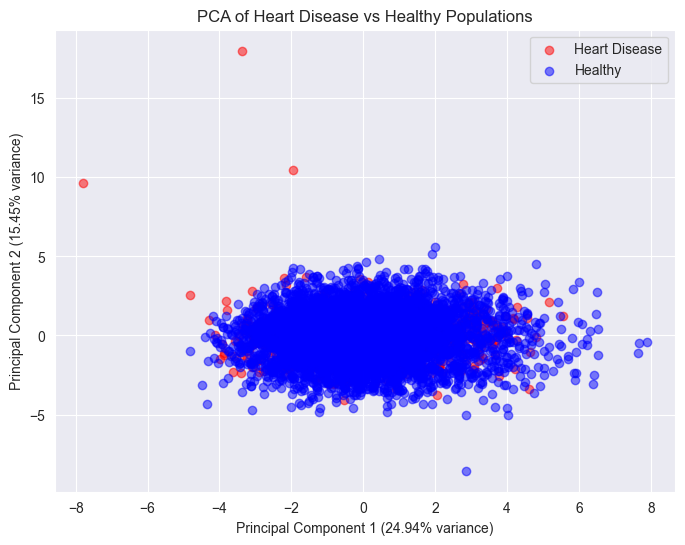

In [16]:
# Apply PCA to both groups
plt.figure(figsize=(8, 6))
variance_ratio_heart = apply_pca(obese_smoker_heart, 'Heart Disease', 'red')
variance_ratio_healthy = apply_pca(healthy_non_smoker, 'Healthy', 'blue')

# Plot customization
plt.title('PCA of Heart Disease vs Healthy Populations')
plt.xlabel(f'Principal Component 1 ({variance_ratio_heart[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({variance_ratio_heart[1]:.2%} variance)')
plt.legend()
plt.grid(True)
plt.show()



In [17]:
pca_df_obese_smoker, variance_ratio_obese = apply_pca_3d(obese_smoker_heart, 'Obese Smoker with Heart Disease')
pca_df_healthy_non_smoker, variance_ratio_healthy = apply_pca_3d(healthy_non_smoker, 'Healthy Non-Smoker')

# Create interactive 3D scatter plot
fig = go.Figure()

# Add Obese Smoker with Heart Disease data with eid in hover
fig.add_trace(go.Scatter3d(
    x=pca_df_obese_smoker['PC1'],
    y=pca_df_obese_smoker['PC2'],
    z=pca_df_obese_smoker['PC3'],
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.6),
    name='Obese Smoker with Heart Disease',
    hovertemplate='eid: %{customdata}<extra></extra>',
    customdata=pca_df_obese_smoker['eid']
))

# Add Healthy Non-Smoker data with eid in hover
fig.add_trace(go.Scatter3d(
    x=pca_df_healthy_non_smoker['PC1'],
    y=pca_df_healthy_non_smoker['PC2'],
    z=pca_df_healthy_non_smoker['PC3'],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.6),
    name='Healthy Non-Smoker',
    hovertemplate='eid: %{customdata}<extra></extra>',
    customdata=pca_df_healthy_non_smoker['eid']
))

# Update layout
fig.update_layout(
    title='3D PCA of Obese Smokers with Heart Disease vs Healthy Non-Smokers',
    scene=dict(
        xaxis_title=f'PC1 ({variance_ratio_obese[0]:.2%} variance)',
        yaxis_title=f'PC2 ({variance_ratio_obese[1]:.2%} variance)',
        zaxis_title=f'PC3 ({variance_ratio_obese[2]:.2%} variance)'
    ),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()

Top features affecting Obese Smoker with Heart Disease variation:
PC1 top features: ['Cholesterol | Instance 0', 'LDL direct | Instance 0'] (Loadings: [0.541, 0.522])
PC2 top features: ['Cystatin C | Instance 0', 'Creatinine | Instance 0'] (Loadings: [0.482, 0.463])
PC3 top features: ['HDL cholesterol | Instance 0', 'Creatinine | Instance 0'] (Loadings: [0.489, 0.483])
Top features affecting Healthy Non-Smoker variation:
PC1 top features: ['LDL direct | Instance 0', 'Apolipoprotein B | Instance 0'] (Loadings: [0.546, 0.537])
PC2 top features: ['HDL cholesterol | Instance 0', 'Apolipoprotein A1 | Instance 0'] (Loadings: [0.504, 0.484])
PC3 top features: ['Creatinine | Instance 0', 'HDL cholesterol | Instance 0'] (Loadings: [0.467, 0.444])
